In [1]:
%load_ext autoreload
%autoreload 2

# Install LightAutoML

Uncomment if doesn't clone repository by git. (ex.: colab, kaggle version)

In [2]:
#! pip install -U lightautoml

# Import necessary libraries

In [3]:
# Standard python libraries
from copy import deepcopy
import os
import requests

# Installed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

from lightautoml.addons.uplift.base import AutoUplift, BaseLearnerWrapper, MetaLearnerWrapper
from lightautoml.addons.uplift import metalearners
from lightautoml.addons.uplift.metrics import (_available_uplift_modes,
                                               TUpliftMetric,
                                               calculate_graphic_uplift_curve,
                                               calculate_min_max_uplift_auc,
                                               calculate_uplift_at_top,
                                               calculate_uplift_auc,
                                               perfect_uplift_curve)
from lightautoml.addons.uplift.utils import create_linear_automl
from lightautoml.report.report_deco import ReportDecoUplift


%matplotlib inline

# Parameters

## Setting

In [4]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 300 # Time in seconds for automl run
TARGET_NAME = 'TARGET' # Target column name
TREATMENT_NAME = 'CODE_GENDER'

## Fix torch number of threads and numpy seed

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Example data load

Load a dataset from the repository if doesn't clone repository by git.

In [6]:
DATASET_DIR = '../data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/example_data/test_data_files/sampled_app_train.csv'

In [7]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

CPU times: user 10 µs, sys: 3 µs, total: 13 µs
Wall time: 15.5 µs


In [8]:
%%time

data = pd.read_csv(DATASET_FULLNAME)
data.head()

CPU times: user 112 ms, sys: 7.53 ms, total: 119 ms
Wall time: 119 ms


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


# (Optional) Some user feature preparation

In [9]:
%%time 

data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)
data['report_dt'] = np.datetime64('2018-01-01')
data['constant'] = 1
data['allnan'] = np.nan
data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)
data['CODE_GENDER'] = (data['CODE_GENDER'] == 'M').astype(int)

CPU times: user 120 ms, sys: 3.49 ms, total: 124 ms
Wall time: 124 ms


# Data splitting for train-test

In [10]:
%%time


stratify_value = data[TARGET_NAME] + 10 * data[TREATMENT_NAME]
train, test = train_test_split(data, test_size=3000, stratify=stratify_value, random_state=42)
test_target, test_treatment = test[TARGET_NAME].values.ravel(), test[TREATMENT_NAME].values.ravel()

CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 14.1 ms


# Setup columns roles

In [11]:
%%time

roles = {
    'target': TARGET_NAME,
    'treatment': TREATMENT_NAME,
    DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt'
}

CPU times: user 31 µs, sys: 9 µs, total: 40 µs
Wall time: 43.2 µs


# Uplift modeling

## AutoUplift (use predefined uplift methods)

### Fit autouplift

In [12]:
%%time

task = Task('binary')

autouplift = AutoUplift(task,
                        metric='adj_qini', 
                        has_report=True,
                        test_size=0.2, 
                        timeout=200,
                        # timeout_metalearner=5
)

autouplift.fit(train, roles, verbose=1)

[22:41:35] Train data shape: (1912, 124)



/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[22:41:36] Layer 1 train process start. Time left 9999999998.82 secs
[22:41:37] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:41:40] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7141811981709679
[22:41:40] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:41:40] Time left 9999999994.88 secs

[22:41:40] Layer 1 training completed.

[22:41:40] Train data shape: (3688, 124)

[22:41:41] Layer 1 train process start. Time left 9999999998.57 secs
[22:41:42] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:41:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7319719953325554
[22:41:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:41:46] Time left 9999999994.05 secs

[22:41:46] Layer 1 training completed.

[22:41:46] Uplift candidate #0 [__TLearner__Default__] is fitted
[22:41:46] Train data shape: (5600, 124)

[22:41:48] Layer 1 train process start. Time left 9999999998.20 secs
[22:41:49] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[22:42:19] Layer 1 train process start. Time left 15.97 secs
[22:42:19] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:42:20] Time limit exceeded after calculating fold 1

[22:42:20] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.749980930587338
[22:42:20] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:42:20] Time left 14.64 secs

[22:42:21] Selector_LightGBM fitting and predicting completed
[22:42:22] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:42:23] Time limit exceeded after calculating fold 1

[22:42:23] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7259725400457666
[22:42:23] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:42:23] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[22:42:25] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.5995876927846238
[22:42:25] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[22:42:25] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time

### Show rating of uplift methods (meta-learners)

In [13]:
%%time

rating_table = autouplift.get_metalearners_ranting()
rating_table

CPU times: user 2.02 ms, sys: 62 µs, total: 2.09 ms
Wall time: 9.32 ms


,MetaLearner,Parameters,Metrics,WorkTime,Rank
0,__XLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.018394,29.222237,1.0
1,__XLearner__TabularAutoML__,"{'timeout': None, 'outcome_learners': [BaseLea...",0.018351,68.154890,2.0
2,__XLearner__Propensity_Linear__Other_TabularAu...,"{'timeout': None, 'outcome_learners': [BaseLea...",0.017160,65.043525,3.0
3,__TLearner__TabularAutoML__,"{'timeout': None, 'treatment_learner': BaseLea...",0.015952,26.132046,4.0
4,__TLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.015536,11.094299,5.0


###  Get best metalearner

In [14]:
%%time 

best_metalearner = autouplift.create_best_metalearner(
    update_metalearner_params={'timeout': None},
    update_baselearner_params={'timeout': 30}
)
best_metalearner.fit(train, roles)
_ = best_metalearner.predict(test);

CPU times: user 1min 22s, sys: 96.4 ms, total: 1min 22s
Wall time: 31 s


### Predict to test data and check metrics

In [15]:
%%time

uplift_pred, treatment_pred, control_pred = best_metalearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.68486
	Control   = 0.73378
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.02609 (0.15667)
	Perfect       = 0.09438
CPU times: user 1.68 s, sys: 0 ns, total: 1.68 s
Wall time: 1.42 s


## AutoUplift (custom uplift methods)

### Fit autouplift

In [16]:
%%time

# Set uplift candidate for choosing best of them
# !!!ATTENTION!!!
#    This is a demonstration of the possibilities, 
#    You may use default set of candidates 

task = Task('binary')

uplift_candidates = [
    MetaLearnerWrapper(
        name='TLearner__Default', 
        klass=metalearners.TLearner, 
        params={'base_task': task}
    ),  
    MetaLearnerWrapper(
        name='TLearner__Custom', 
        klass=metalearners.TLearner, 
        params={
            'treatment_learner': BaseLearnerWrapper(
                name='__TabularAutoML__',
                klass=TabularAutoML, 
                params={'task': task, 'timeout': 10}),
            'control_learner': BaseLearnerWrapper(
                name='__Linear__',
                klass=create_linear_automl,
                params={'task': Task('binary')})
        }
    ),
    MetaLearnerWrapper(
        name='XLearner__Custom',
        klass=metalearners.XLearner,
        params={
            'outcome_learners': [
                TabularAutoML(task=task, timeout=10), # [sec] , Only speed up example, don't change it!
                create_linear_automl(task=Task('binary'))
            ],
            'effect_learners': [BaseLearnerWrapper(
                name='__TabularAutoML__',
                klass=TabularAutoML, 
                params={'task': Task('reg'), 'timeout': 5})],
            'propensity_learner': create_linear_automl(task=Task('binary')),
        }    
    )
]

autouplift = AutoUplift(task,
                        uplift_candidates=uplift_candidates, 
                        metric='adj_qini', 
                        test_size=0.2, 
                        threshold_imbalance_treatment=0.0,    # Doesn't affect, see warnings
                        timeout=600)                          # Doesn't affect, see warnings

autouplift.fit(train, roles, verbose=1)

[22:45:33] Train data shape: (1912, 124)



/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[22:45:34] Layer 1 train process start. Time left 9999999998.84 secs
[22:45:35] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:45:38] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7141811981709679
[22:45:38] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:45:38] Time left 9999999995.36 secs

[22:45:38] Layer 1 training completed.

[22:45:38] Train data shape: (3688, 124)

[22:45:39] Layer 1 train process start. Time left 9999999998.60 secs
[22:45:40] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:45:44] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7320280944259939
[22:45:44] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:45:44] Time left 9999999994.20 secs

[22:45:44] Layer 1 training completed.

[22:45:44] Uplift candidate #0 [TLearner__Default] is fitted
[22:45:44] Stdout logging level is INFO.
[22:45:44] Task: binary

[22:45:44] Start automl preset with listed constraints:
[22:45:44] - time: 10.00 seconds
[22:45:44] - CPU

/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[22:45:45] Layer 1 train process start. Time left 9.29 secs
[22:45:45] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:45:46] Time limit exceeded after calculating fold 0

[22:45:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7456903127383676
[22:45:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:45:46] Time left 8.27 secs

[22:45:47] Selector_LightGBM fitting and predicting completed
[22:45:47] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:45:48] Time limit exceeded after calculating fold 0

[22:45:48] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7342486651411136
[22:45:48] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:45:48] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[22:45:50] Time limit exceeded after calculating fold 3

[22:45:50] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.6209033816425121
[22:45:50] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[22:45:50] Start hyperparameters opt

### Show rating of uplift methods (meta-learners)

In [17]:
%%time

rating_table = autouplift.get_metalearners_ranting()
rating_table

CPU times: user 2.2 ms, sys: 53 µs, total: 2.25 ms
Wall time: 2.26 ms


,MetaLearner,Parameters,Metrics,WorkTime,Rank
0,XLearner__Custom,{'outcome_learners': [<lightautoml.automl.pres...,0.023277,33.739863,1.0
1,TLearner__Custom,{'treatment_learner': BaseLearnerWrapper(name=...,0.017351,14.351422,2.0
2,TLearner__Default,{'base_task': <lightautoml.tasks.base.Task obj...,0.015533,10.456704,3.0


### Predict to test data and check metrics

In [18]:
%%time

uplift_pred, treatment_pred, control_pred = autouplift.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.68953
	Control   = 0.73887
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.03006 (0.20575)
	Perfect       = 0.09438
CPU times: user 2.11 s, sys: 7.99 ms, total: 2.12 s
Wall time: 1.66 s


## AutoUplift with custom metric

### Fit autouplift

In [19]:
%%time

# Using a custom metric
# How to determine custom metric, see below

task = Task('binary')


class CustomUpliftMetric(TUpliftMetric):
    def __call__(self, target: np.ndarray, uplift_pred: np.ndarray, treatment: np.ndarray) -> float:
        up_10 = calculate_uplift_at_top(target, uplift_pred, treatment, 10)
        up_20 = calculate_uplift_at_top(target, uplift_pred, treatment, 20)
    
        return 0.5 * (up_10 + up_20)

autouplift = AutoUplift(task,
                        add_dd_candidates=True,
                        metric=CustomUpliftMetric(), 
                        test_size=0.2, 
                        threshold_imbalance_treatment=0.0,
                        cpu_limit=10,
                        timeout=100)

autouplift.fit(train, roles)

/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/lightautoml/addons/uplift/metalearners.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

CPU times: user 4min 49s, sys: 407 ms, total: 4min 50s
Wall time: 1min 41s


### Show rating of uplift methods (meta-learners)

In [20]:
%%time

rating_table = autouplift.get_metalearners_ranting()
rating_table

CPU times: user 1.7 ms, sys: 31 µs, total: 1.73 ms
Wall time: 1.74 ms


,MetaLearner,Parameters,Metrics,WorkTime,Rank
0,__RLearner__Linear__,"{'timeout': None, 'propensity_learner': BaseLe...",0.049947,22.639386,1.0
1,__XLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.049314,28.107533,2.0
2,__TLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.024465,10.493419,3.0
3,__TDLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,0.020878,10.466031,4.0
4,__SLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,-0.035616,6.442055,5.0
5,__RLearner__Default__,{'base_task': <lightautoml.tasks.base.Task obj...,NaN,20.717669,NaN
6,__SLearner__TabularAutoML__,"{'timeout': None, 'learner': BaseLearnerWrappe...",NaN,NaN,NaN
7,__TLearner__TabularAutoML__,"{'timeout': None, 'treatment_learner': BaseLea...",NaN,NaN,NaN
8,__TDLearner__TabularAutoML__,"{'timeout': None, 'treatment_learner': BaseLea...",NaN,NaN,NaN
9,__XLearner__Propensity_Linear__Other_TabularAu...,"{'timeout': None, 'outcome_learners': [BaseLea...",NaN,NaN,NaN


## MetaLearner

### TLearner

#### Fit on train data

In [21]:
%%time

# Default setting
tlearner = metalearners.TLearner(base_task=Task('binary'), cpu_limit=5)
tlearner.fit(train, roles)

/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


CPU times: user 30.8 s, sys: 19 ms, total: 30.8 s
Wall time: 10.9 s


#### Predict to test data and check metrics

In [22]:
%%time

uplift_pred, treatment_pred, control_pred = tlearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.68478
	Control   = 0.73096
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.01619 (0.03444)
	Perfect       = 0.09438
CPU times: user 647 ms, sys: 0 ns, total: 647 ms
Wall time: 517 ms


### XLearner

#### Fit on train data

In [23]:
%%time

# Custom base algorithm
xlearner = metalearners.XLearner(
    propensity_learner=TabularAutoML(task=Task('binary'), timeout=10),
    outcome_learners=[
        TabularAutoML(task=Task('binary'), timeout=10),
        TabularAutoML(task=Task('binary'), timeout=10)
    ],
    effect_learners=[
        TabularAutoML(task=Task('reg'), timeout=10),
        TabularAutoML(task=Task('reg'), timeout=10)
    ]
)
xlearner.fit(train, roles)

CPU times: user 2min 36s, sys: 3.3 s, total: 2min 40s
Wall time: 49.8 s


#### Predict to test data and check metrics

In [24]:
%%time

uplift_pred, treatment_pred, control_pred = xlearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.67998
	Control   = 0.72480
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.02908 (0.19357)
	Perfect       = 0.09438
CPU times: user 2.36 s, sys: 12.8 ms, total: 2.37 s
Wall time: 1.71 s


# Uplift metrics and graphics (using xlearner predictions)

In [25]:
%%time 

UPLIFT_METRIC = 'adj_qini'

print("All available uplift metrics: {}".format(_available_uplift_modes))

All available uplift metrics: ('qini', 'cum_gain', 'adj_qini')
CPU times: user 53 µs, sys: 1 µs, total: 54 µs
Wall time: 57.2 µs


## Algorithm uplift curve 

In [26]:
%%time

# Algorithm curve
xs_xlearner, ys_xlearner = calculate_graphic_uplift_curve(
    test_target, uplift_pred, test_treatment, mode=UPLIFT_METRIC
)

CPU times: user 575 µs, sys: 11 µs, total: 586 µs
Wall time: 589 µs


## Baseline, perfect curve

In [27]:
# Baseline curve
xs_base, ys_base = xs_xlearner, xs_xlearner * ys_xlearner[-1]

# Perfect curver
perfect_uplift = perfect_uplift_curve(test_target, test_treatment)
xs_perfect, ys_perfect = calculate_graphic_uplift_curve(
    test_target, perfect_uplift, test_treatment, mode=UPLIFT_METRIC)

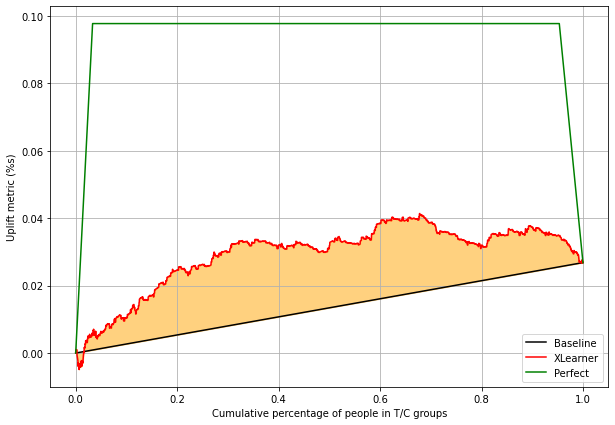

In [28]:
plt.figure(figsize=(10, 7))

plt.plot(xs_base, ys_base, 'black')
plt.plot(xs_xlearner, ys_xlearner, 'red')
plt.plot(xs_perfect, ys_perfect, 'green')

plt.fill_between(xs_xlearner, ys_base, ys_xlearner, alpha=0.5, color='orange')

plt.xlabel('Cumulative percentage of people in T/C groups')
plt.ylabel('Uplift metric (%s)'.format(UPLIFT_METRIC))
plt.grid()
plt.legend(['Baseline', 'XLearner', 'Perfect']);

## Uplift TOP-K

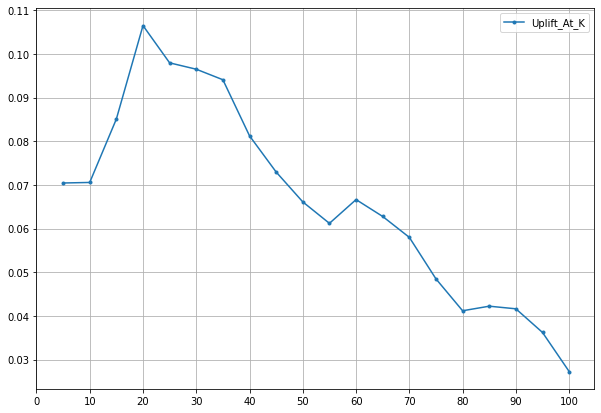

In [29]:
tops = np.arange(5, 101, 5)

uplift_at_tops = []
for top in tops:
    uat = calculate_uplift_at_top(test_target, uplift_pred, test_treatment, top=top)
    uplift_at_tops.append(uat)

plt.figure(figsize=(10, 7))

plt.plot(tops, uplift_at_tops, marker='.')

plt.legend(['Uplift_At_K'])
plt.xticks(np.arange(0, 101, 10))
plt.grid()

## Custom metric

In [30]:
# Custom metric can be used in AutoUplift
# There msut be a function's signature:
# def custom_metric(target, uplift_pred, treatment) -> float:


class CustomUpliftMetric(TUpliftMetric):
    def __call__(self, target: np.ndarray, uplift_pred: np.ndarray, treatment: np.ndarray) -> float:
        up_10 = calculate_uplift_at_top(target, uplift_pred, treatment, 10)
        up_20 = calculate_uplift_at_top(target, uplift_pred, treatment, 20)
    
        return 0.5 * (up_10 + up_20)


metric = CustomUpliftMetric()
metric_value = metric(test_target, uplift_pred, test_treatment)

print("Metric = {}".format(metric_value))

Metric = 0.08856084688484302


# Report

In [31]:
%%time

RDU = ReportDecoUplift()
tlearner_deco = RDU(metalearners.TLearner(base_task=Task('binary')))
tlearner_deco.fit(train, roles)
_ = tlearner_deco.predict(test)

# Path to report: PATH_TO_CURRENT_NOTEBOOK/lama_report/lama_interactive_report.html

/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/alexander/workspace/projects/sberbank_ai_lab/LightAutoML/.venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


AttributeError: 'ReportDecoUplift' object has no attribute '_text_features_table'